In [1]:
# =============================================================================
# ## 1. GEE Data Extraction
# 
# This notebook connects to Google Earth Engine (GEE) to extract a time-series
# of NDVI data for multiple remote sensing platforms (Sentinel-2, MODIS). 
# It reads field polygon data, loops through each sensor and polygon, 
# fetches the data via GEE's API, and saves the results to local CSV files.
# The code is structured to be resumable, meaning it will check for existing
# output files and only process the missing fields.
# =============================================================================

# ### Import Libraries
import ee
import geopandas as gpd
import pandas as pd
import os
from tqdm.notebook import tqdm
import json
import datetime
import time
import sys
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Add custom scripts to the path ---
# This allows us to import our custom functions from the 'scripts' directory.
sys.path.append('../scripts')
import gee_functions as fgee

In [2]:
# --- Initialize Google Earth Engine ---
# This step authenticates and initializes the GEE API session.
# Make sure to replace 'your-gee-project-id' with your actual GEE project name.

try:
    ee.Initialize()#project='your-gee-project-id'
except Exception:
    ee.Authenticate()
    ee.Initialize()#project='your-gee-project-id'

In [3]:
# Set Parameters and Run Extraction ---
# Extracting a higher time-series. That will be "reduce later"
start_date = '2022-01-01'
end_date = '2023-12-31'
output_dir = '../output/raw_timeseries/'
plot_output_dir = '../output/plots/'
os.makedirs(plot_output_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
# --- Load and Prepare Field Data ---
path_field_data = '../data/field_data/samples-bihar.geojson' # Example path
# path_field_data = '../data/field_data/field_data_merge_bihar.gpkg' # Example path
gdf = gpd.read_file(path_field_data)#.to_crs('EPSG:4326')
print(f"Loaded {len(gdf)} field locations.")
print(f"Unique IDs: {gdf.fkey.nunique()}")

# Explode multipolygons into single polygons to prevent GEE errors
if 'MultiPolygon' in gdf.geom_type.unique():
    print("Exploding MultiPolygons to Polygons...")
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
print(f"Loaded and prepared {len(gdf)} field polygons.")

Loaded 37 field locations.
Unique IDs: 37
Exploding MultiPolygons to Polygons...
Loaded and prepared 37 field polygons.


In [4]:
# Datasets
rs_datasets ={"sentinel-2":{'path_ee':'COPERNICUS/S2_SR_HARMONIZED', 'scale': 10 , 'path_aux': 'COPERNICUS/S2_CLOUD_PROBABILITY', 'clouds': 100 },
               "MODIS":{'path_ee':'MODIS/061/MOD09GQ', 'scale': 10,'path_aux': 'MODIS/061/MOD09GA', 'clouds': 100},
                "HLS":{'path_ee':'NASA/HLS/HLSS30/v002', 'scale': 30, 'path_aux': 'NASA/HLS/HLSL30/v002', 'clouds': 100} #HLS data is avaliable on GEE, but at the point of this publication the data were not completed uploaded
               }
# GEE reducers
reducers_ee = {"mean": ee.Reducer.mean(),
            "median": ee.Reducer.median(),
            "stdDev": ee.Reducer.stdDev(),
            "mode": ee.Reducer.mode(),
            "min": ee.Reducer.min(),
            "max": ee.Reducer.max(),
            "variance": ee.Reducer.variance(),
            "count": ee.Reducer.count()        
            }
# What reducers we want to use.
reducers = ["mean"]# ["mean", "median", "mode", "count"]

In [5]:

# =============================================================================
# ## 2. Helper Functions
# 
# These functions organize the workflow into logical, reusable steps.
# =============================================================================

## Checking if the file was processed
def check_file_status(filepath, full_gdf):
    """
    Checks if an output file exists and determines which fkeys still need processing.
    Includes a check to handle cases where the file exists but is empty.

    Args:
        filepath (str): The full path to the output CSV file.
        full_gdf (GeoDataFrame): The complete GeoDataFrame with all fkeys.

    Returns:
        tuple: A tuple containing:
            - ids_to_process (list): A list of fkeys that need to be processed.
            - df_existing (DataFrame): DataFrame of already processed data.
    """
    # First, check if the file exists on disk.
    if os.path.isfile(filepath):
        print(f"File {filepath} already exists. Checking status...")
        try:
            # Attempt to read the CSV file.
            df_existing = pd.read_csv(filepath)
            
            # NEW: Check if the DataFrame is empty or if the 'fkey' column is missing.
            # This handles files that were created but contain no data.
            if df_existing.empty or 'fkey' not in df_existing.columns:
                print("Existing file is empty or malformed. Reprocessing all fields.")
                return full_gdf["fkey"].unique(), pd.DataFrame()

        except pd.errors.EmptyDataError:
            # This case handles files that are completely empty (0 bytes).
            print("Existing file is empty. Reprocessing all fields.")
            return full_gdf["fkey"].unique(), pd.DataFrame()

        # If the file is valid and contains data, proceed with the original logic.
        # Find which fkeys from the main GDF are not in the existing file.
        processed_fkeys = df_existing['fkey'].unique()
        fkeys_to_process = full_gdf[~full_gdf["fkey"].isin(processed_fkeys)]["fkey"].unique()

        if len(fkeys_to_process) == 0:
            print("All fields already processed. Skipping.")
            return [], df_existing
        else:
            print(f"Resuming process for {len(fkeys_to_process)} remaining fields.")
            return fkeys_to_process, df_existing
    else:
        # If the file doesn't exist at all, process all fkeys from scratch.
        print("No existing file found. Starting a new extraction.")
        return full_gdf["fkey"].unique(), pd.DataFrame()

def get_data_for_polygon(fkey, sensor, sensor_params, gdf, reducer_name, reducer):
    """
    Fetches GEE time-series data for a single polygon (fkey).

    Args:
        fkey (int): The unique identifier for the field polygon.
        sensor (str): The name of the sensor ('sentinel-2' or 'MODIS').
        sensor_params (dict): A dictionary with the 'path_ee' and 'scale'.
        gdf (GeoDataFrame): The main GeoDataFrame to look up the fkey.

    Returns:
        DataFrame: A pandas DataFrame with the time-series data, or None if an error occurs.
    """
    try:
        # Get the specific polygon geometry
        pol = gdf[gdf["fkey"]==fkey]
        g = json.loads(pol['geometry'].to_json())
        coords = g['features'][0]['geometry']['coordinates']
        polygon = ee.Geometry.Polygon(coords)
        path_ee = sensor_params["path_ee"]
        path_aux = sensor_params["path_aux"]
        # --- Sensor-specific GEE Collection and Processing ---
        if sensor == 'sentinel-2':
            #Creates a Sentinel-2/MSI level-2A ee.ImageCollection for the ROI between estart and end dates
            s2_sr = fgee.get_collection(start_date, end_date, polygon, collection=path_ee)
            # Applies the cloud mask and calculates the NDVI
            s2_sr = s2_sr.map(fgee.calc_ndvi_s2)
            s2_cloud_prob = fgee.get_collection(start_date, end_date, polygon, collection=path_aux)
            s2S_sr_with_cloud_mask = ee.Join.saveFirst('cloud_mask').apply(
                primary=s2_sr.map(fgee.mask_edges).map(fgee.cloud_mask_qa),
                secondary=s2_cloud_prob,
                condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))
            imgCollection = ee.ImageCollection(s2S_sr_with_cloud_mask).map(fgee.cloud_mask_probability)
            ## adding a mask band to the image collection
            imgCollection = imgCollection.map(fgee.add_mask_band_s2)

            #get the nominal scale from one image
            scale = ee.Image(imgCollection.first().select("B8")).projection().nominalScale().round()
            # scale = sensor_params["scale"] # if you want to use the value from the dict.
        elif sensor == 'MODIS':
            imgCollection = fgee.modis_250m_daily(path_ee, path_aux, start_date, end_date, polygon)
            imgCollection = imgCollection.map(fgee.calc_ndvi_modis)

            ## adding a mask band to the image collection
            imgCollection = imgCollection.map(fgee.add_mask_band_modis)
            #get the nominal escale
            scale = ee.Image(imgCollection.first().select("red")).projection().nominalScale().round()
            # scale = sensor_params["scale"] # if you want to use the value from the dict.
        elif sensor == "HLS":
            hlss, hlsl = fgee.hls_30m_daily(path_ee, path_aux, start_date, end_date, polygon)
            hlss = hlss.map(fgee.mask_fmask)
            hlsl = hlsl.map(fgee.mask_fmask)
            # List common bands and rename
            common_bands_s30 = ['B1', 'B2', 'B3', 'B4', 'B8A', 'B11', 'B12']  # Bands to keep from S30
            common_bands_l30 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']  # Bands to keep from L30

            new_band_names = ['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']  # New names for common bands
            # Rename bands in S30 and L30 images
            hlss = hlss.select(common_bands_s30, new_band_names)
            hlsl = hlsl.select(common_bands_l30, new_band_names)

            # Merge the two collections and sort by system:time_start
            imgCollection = hlss.merge(hlsl).sort('system:time_start')
            imgCollection = imgCollection.map(fgee.calc_ndvi_hls)

            ## adding a mask band to the image collection
            imgCollection = imgCollection.map(fgee.add_mask_band_hls)
            #get the nominal escale
            scale = ee.Image(imgCollection.first().select("NIR")).projection().nominalScale().round() 
            # print(imgCollection.size().getInfo(), "size")
                
        else:
            return None # Skip unsupported sensors

        # --- Reduce the Image Collection ---
        reduce_function = fgee.create_reduce_region_function(polygon, reducer, scale)
        roi_stats = ee.FeatureCollection(imgCollection.map(reduce_function))#.filter(ee.Filter.notNull(['NDVI']))
        
        # --- Fetch Data and Format ---
        df_stats = ee.data.computeFeatures({'expression': roi_stats, 'fileFormat': 'PANDAS_DATAFRAME'})

        ###Creating a function to calculate the pixel count for the ROI    
        pixel_count_function = fgee.create_pixel_count_function(polygon, scale=scale)#rs_datasets[sensor]["scale"]
        roi_pixel_counts = ee.FeatureCollection(imgCollection.map(pixel_count_function))
        df_pixel_counts = ee.data.computeFeatures({'expression': roi_pixel_counts, 'fileFormat': 'PANDAS_DATAFRAME'})

        # Convert pixel count results to appropriate format for pandas DataFrame
        df_stats['total_pixels'] = df_pixel_counts['total_pixels']
        df_stats['masked_pixels'] = df_pixel_counts['masked_pixels']
        df_stats['unmasked_pixels'] = df_pixel_counts['unmasked_pixels']
        df_stats['total_area'] = df_pixel_counts['total_area']
        df_stats['masked_area'] = df_pixel_counts['masked_area']
        df_stats['unmasked_area'] = df_pixel_counts['unmasked_area']


        df_stats

        if not df_stats.empty:

            # Check if the are multiple tiles for the polygon    
            df_stats['tile'] = df_stats['id'].apply(lambda x: x.split('_')[-1])
            # in some cases the field is over two tiles, so here i will be using the time-series from the most commom tile
            tiles = list(df_stats.tile)
            if ((sensor == "sentinel-2")or(sensor == "hls"))and len(list(set(tiles)))>1:
                
                # Count occurrences of each element in the list
                element_counts = Counter(tiles)

                # Find the most common element and its count
                most_common_element = element_counts.most_common(1)[0][0]
                count_of_most_common_element = element_counts.most_common(1)[0][1]
                df_stats = df_stats[df_stats["tile"]==most_common_element]

            df_stats['fkey'] = fkey
            df_stats['Timestamp'] = pd.to_datetime(df_stats['millis'], unit='ms')
            # df_stats['tile'] = df_stats['id'].apply(lambda x: x.split('_')[-1])
            df_stats["day"] = df_stats.Timestamp.apply(lambda x: datetime.datetime.strptime(str(x.date()),  '%Y-%m-%d'))
            return df_stats
        
        return None

    except Exception as e:
        print(f"ERROR on fkey {fkey} for sensor {sensor}: {e}")
        return None

In [6]:

# =============================================================================
# ## 3. Main Extraction Workflow
# =============================================================================



# --- Start the Main Loop ---
for sensor, params in rs_datasets.items():
    print(f"\n===== Processing Sensor: {sensor} =====")
    for reducer_name in reducers:
        # Define the output file path for this sensor
        path_file = os.path.join(output_dir, f'gee_metrics_{sensor}_data_{start_date}_to_{end_date}_{reducer_name}.csv')
        
        # get the reducer
        reducer = reducers_ee[reducer_name]

        # 1. Check which fkeys need to be processed
        ids_to_process, df_existing = check_file_status(path_file, gdf)
        
        if not ids_to_process.any():
            continue # Skip if there's nothing to do
        
        # 2. Loop through only the necessary fkeys and fetch data
        all_new_data = [df_existing]
        for fkey in tqdm(ids_to_process, desc=f"Extracting {sensor} data"):
            df_poly_data = get_data_for_polygon(fkey, sensor, params, gdf, reducer_name, reducer)
            if df_poly_data is not None:
                all_new_data.append(df_poly_data)
            else:
                print(f"Failed for {fkey}, sensor {sensor}")

        # 3. Combine and save the results
        if len(all_new_data) > 0:
            final_df = pd.concat(all_new_data, ignore_index=True)
            final_df.to_csv(path_file, index=False)
            print(f"Successfully saved updated data for {sensor} to {path_file}")

print("\n--- All processing complete. ---")


===== Processing Sensor: sentinel-2 =====
No existing file found. Starting a new extraction.


Extracting sentinel-2 data:   0%|          | 0/37 [00:00<?, ?it/s]

Successfully saved updated data for sentinel-2 to ../output/raw_timeseries/gee_metrics_sentinel-2_data_2022-01-01_to_2023-12-31_mean.csv

===== Processing Sensor: MODIS =====
No existing file found. Starting a new extraction.


Extracting MODIS data:   0%|          | 0/37 [00:00<?, ?it/s]

Successfully saved updated data for MODIS to ../output/raw_timeseries/gee_metrics_MODIS_data_2022-01-01_to_2023-12-31_mean.csv

===== Processing Sensor: HLS =====
No existing file found. Starting a new extraction.


Extracting HLS data:   0%|          | 0/37 [00:00<?, ?it/s]

Successfully saved updated data for HLS to ../output/raw_timeseries/gee_metrics_HLS_data_2022-01-01_to_2023-12-31_mean.csv

--- All processing complete. ---


In [7]:
ids_to_process

array([116,  10,  47,  69,  77,  96,  97, 105,  49, 125, 128, 130, 131,
       139, 165, 217, 225, 238, 244, 245, 253, 273, 276, 278, 279, 287,
       365, 373, 386, 392, 393, 401, 421, 424, 426, 427, 435], dtype=int32)


--- Starting Plot Generation ---
Generating NDVI profiles for 37 unique polygons...
Displaying plot for Polygon ID: 116


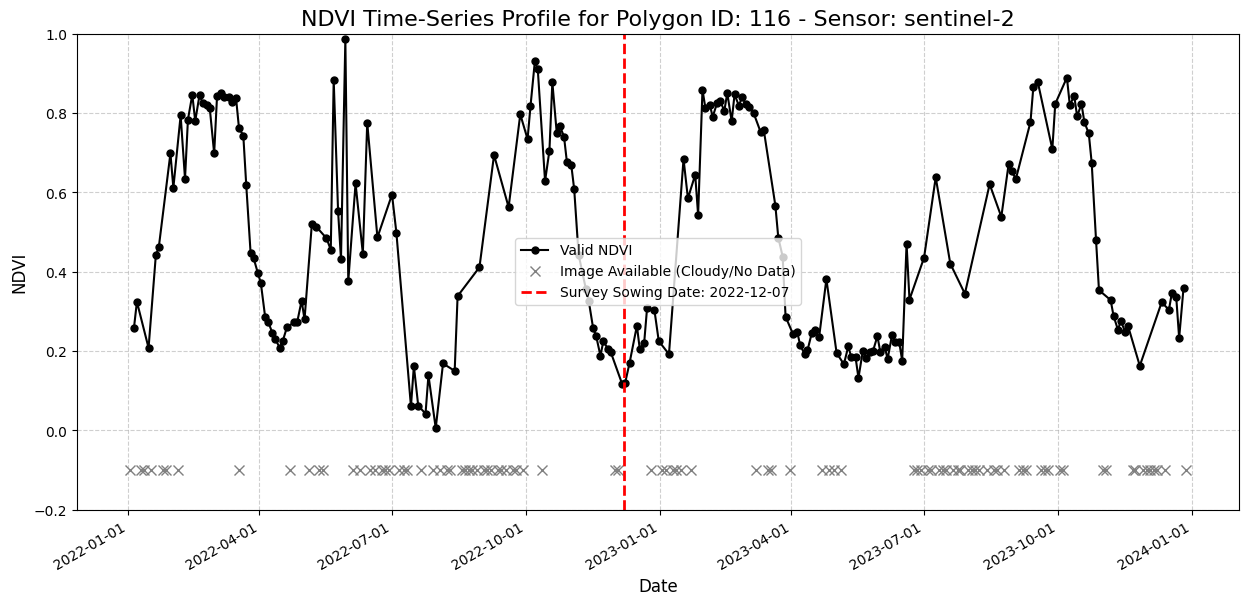

Displaying plot for Polygon ID: 10


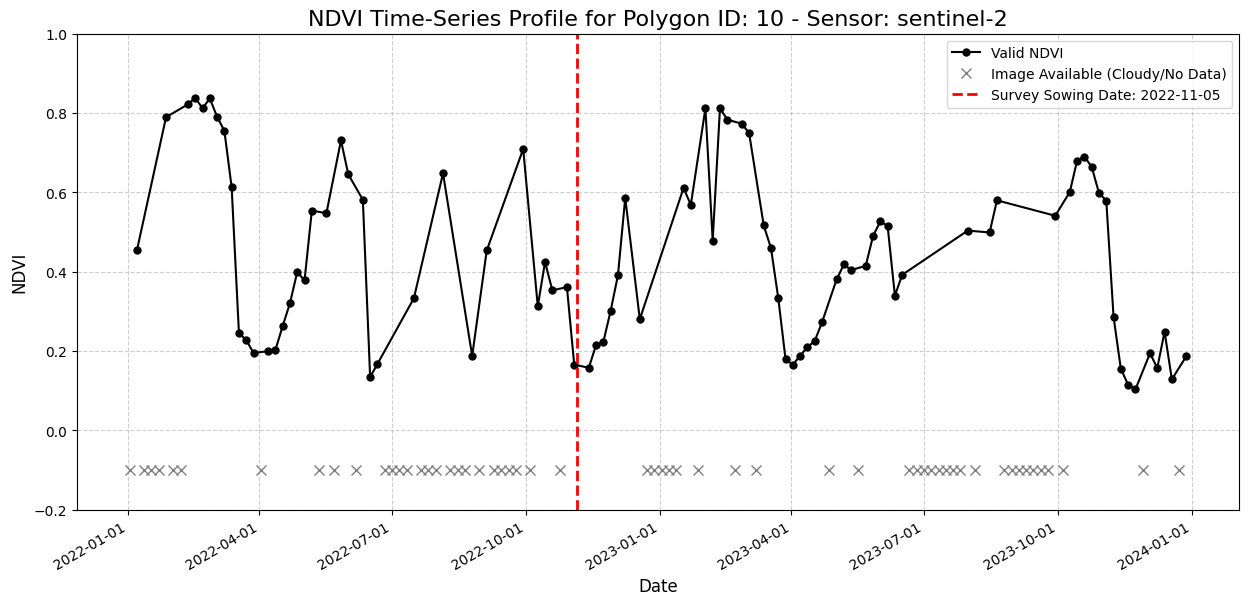

Displaying plot for Polygon ID: 47


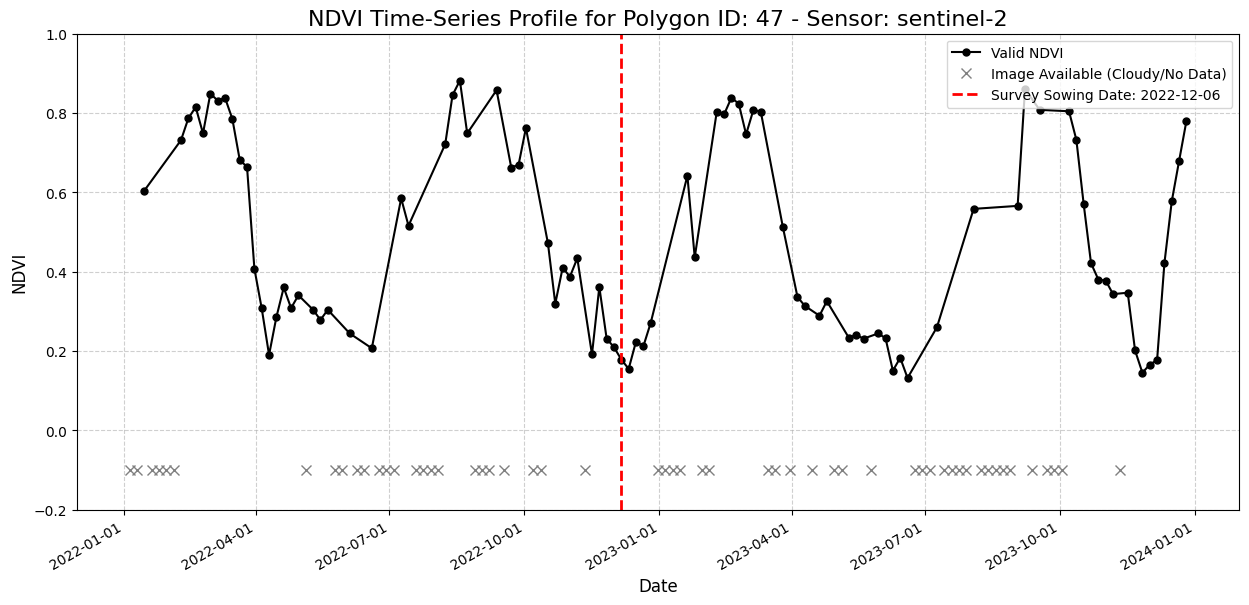

Displaying plot for Polygon ID: 69


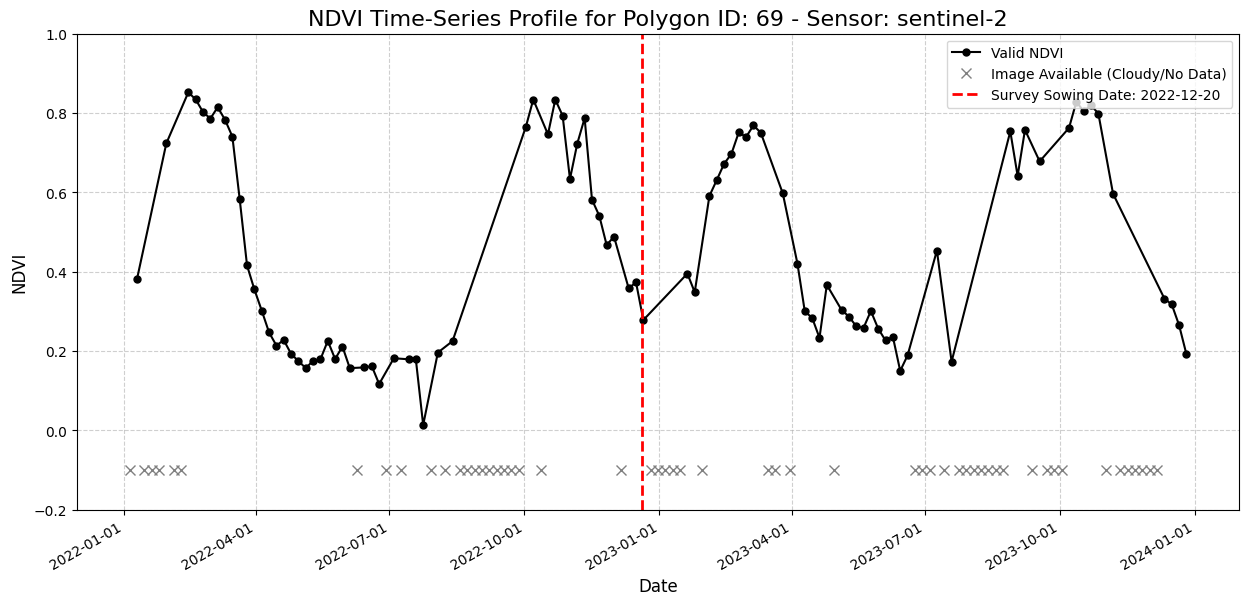


--- All plots have been generated. ---


In [8]:
print("\n--- Starting Plot Generation ---")
sensor = "sentinel-2" #HLS or MODIS or sentinel-2
reducer_name = "mean"
df = pd.read_csv(os.path.join(output_dir, f'gee_metrics_{sensor}_data_{start_date}_to_{end_date}_{reducer_name}.csv'))
# Check if the final DataFrame is empty before proceeding
if df.empty:
    print("Final DataFrame is empty. No data available to plot.")
else:
    # Get the list of unique polygon IDs to iterate over
    unique_ids = df['fkey'].unique()
    
    print(f"Generating NDVI profiles for {len(unique_ids)} unique polygons...")

    # Loop through each unique polygon ID
    for polygon_id in unique_ids[0:4]:#remove [0:4] to plot all
        
        # --- 1. Filter data for the current polygon ---
        # Create a separate DataFrame for the current polygon to avoid modifying the original
        polygon_df = df[df['fkey'] == polygon_id].copy()
        
        # Getting the sowing date
        sowing_date = gdf[gdf['fkey']==polygon_id]["sow_2022"].values[0]

        # Ensure the 'date' column is in a proper datetime format for plotting
        polygon_df['day'] = pd.to_datetime(polygon_df['day'])
        
        # Sort the data by date to ensure the line plot connects points correctly
        polygon_df = polygon_df.sort_values(by='day')
        
        # --- 2. Separate data into valid and NA (Not a Number) NDVI values ---
        valid_ndvi = polygon_df.dropna(subset=['NDVI'])
        na_ndvi = polygon_df[polygon_df['NDVI'].isna()]

        # --- 3. Create the plot ---
        fig, ax = plt.subplots(figsize=(15, 7))
        
        # --- 4. Plot the data points ---
        # Plot valid NDVI data as a black line with points
        if not valid_ndvi.empty:
            ax.plot(valid_ndvi['day'], valid_ndvi['NDVI'], 'o-', color='black', label='Valid NDVI', markersize=5, linewidth=1.5)
        
        # Plot dates where NDVI is NA as gray 'x' markers near the bottom
        # This visually indicates that an image was available on that date,
        # but the data was unusable (e.g., cloudy).
        if not na_ndvi.empty:
            # Plot them at a low, fixed y-value for visibility
            ax.plot(na_ndvi['day'], [-0.1] * len(na_ndvi), 'x', color='gray', label='Image Available (Cloudy/No Data)', markersize=7)
        
        # --- 5. Sowing date ---
        # Add a vertical line to indicate the ground-truth sowing date
        ax.axvline(x=sowing_date, color='red', linestyle='--', linewidth=2, label=f'Survey Sowing Date: {pd.to_datetime(sowing_date).strftime("%Y-%m-%d")}')
        
        # --- 6. Customize the plot for clarity ---
        ax.set_title(f'NDVI Time-Series Profile for Polygon ID: {polygon_id} - Sensor: {sensor}', fontsize=16)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('NDVI', fontsize=12)
        
        # Set a standard y-axis range for NDVI
        ax.set_ylim(-0.2, 1.0)
        
        # Add a grid for easier reading
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add a legend to explain the plot elements
        ax.legend()
        
        # Improve the formatting of date labels on the x-axis
        fig.autofmt_xdate() # Rotates and aligns dates nicely
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
        # --- 7. Display the plot ---
        # This will show one plot at a time. Close the plot window to see the next one.
        print(f"Displaying plot for Polygon ID: {polygon_id}")
       
        # Construct a unique filename for the plot
        plot_filename = f"{sensor}_profile_{polygon_id}_raw.png"
        full_plot_path = os.path.join(plot_output_dir, plot_filename)
        
        # Save the figure
        plt.savefig(full_plot_path, dpi=150, bbox_inches='tight')
        plt.show()
        # Close the figure to free up memory
        plt.close(fig)

print("\n--- All plots have been generated. ---")